https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [27]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
%matplotlib inline

In [5]:
env = gym.make('FrozenLake-v0')

In [24]:
Q = np.zeros([env.observation_space.n, env.action_space.n])

lr = 0.85
gamma = 0.99
num_episodes = 2000

rewards = []

for i_episode in tqdm.tqdm(range(num_episodes)):
    observation = env.reset()
    rewards_sum = 0
    
    for t in range(100):
        available_actions_rewards = Q[observation, :]
        random_rewards_vector = np.random.randn(1, env.action_space.n)
        greedy_action = np.argmax(available_actions_rewards + random_rewards_vector * (1. / (i_episode + 1)))
        
        observation_after, reward, done, _ = env.step(greedy_action)
        
        reward_expected = Q[observation, greedy_action]
        best_next_reward = np.max(Q[observation_after, :])
        Q[observation, greedy_action] = reward_expected + lr * (reward + gamma * best_next_reward - reward_expected)
        
        rewards_sum += reward
        observation = observation_after
        if done:
            break
    
    rewards.append(rewards_sum)
    
print(sum(rewards) / num_episodes)

100%|██████████| 2000/2000 [00:03<00:00, 577.47it/s]

0.5045


In [25]:
print(Q)

[[  3.49740608e-01   8.08446167e-03   8.46672286e-03   8.51027963e-03]
 [  1.91078458e-03   1.98719131e-04   1.25998849e-06   4.12917508e-01]
 [  2.32468252e-03   1.83697164e-03   6.79611121e-03   3.20629526e-01]
 [  8.93124235e-04   2.10759833e-04   7.57633581e-03   3.15062905e-01]
 [  5.45275795e-01   6.61156489e-03   1.30173165e-03   1.95483535e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.58067523e-04   4.37604942e-05   4.06364804e-01   2.53347701e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.29516540e-03   8.32084441e-04   1.82947567e-03   6.78799392e-01]
 [  0.00000000e+00   3.14667011e-01   5.25239063e-05   0.00000000e+00]
 [  2.84848695e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   8.38640090e-01   0.00000000e+00]
 [  0.

In [68]:
tf.reset_default_graph()

In [69]:
# Forward
inputs = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4], 0, 0.01))
Q_out = tf.matmul(inputs, W)
prediction = tf.argmax(Q_out, 1)

# Loss
Q_next = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(Q_next - Q_out))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
update_model = trainer.minimize(loss)

In [71]:
init = tf.initialize_all_variables()

gamma = .99
epsilon = .1
num_episodes = 2000

steps = []
rewards = []

with tf.Session() as session:
    session.run(init)
    
    for i_episode in tqdm.tqdm(range(num_episodes)):
        observation = env.reset()
        rewards_sum = 0
        
        for t in range(100):
            
            onehot_state = np.identity(16)[observation: observation + 1]
            greedy_action, all_Q = session.run([prediction, Q_out], feed_dict={inputs: onehot_state})
            
            if np.random.rand(1) < epsilon:
                greedy_action[0] = env.action_space.sample()
                
            observation_after, reward, done, _ = env.step(greedy_action[0])
            
            onehot_state_after = np.identity(16)[observation_after: observation_after + 1]
            Q = session.run(Q_out, feed_dict={inputs: onehot_state_after})
            Q_max = np.max(Q)
            Q_target = all_Q
            Q_target[0, greedy_action[0]] = reward + gamma * Q_max
            
#             onehot_state = np.identity(16)[observation: observation + 1]
            _, W_after = session.run([update_model, W], feed_dict={inputs: onehot_state, Q_next: Q_target})
            
            rewards_sum += reward
            observation = observation_after
            
            if done:
                epsilon = 1./(i_episode / 50. + 10.)
                break
                
        steps.append(t)
        rewards.append(reward)
        
sum(rewards) / num_episodes

100%|██████████| 2000/2000 [01:06<00:00, 29.96it/s]


0.315

/Users/derrkater/anaconda/envs/gym_openai/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


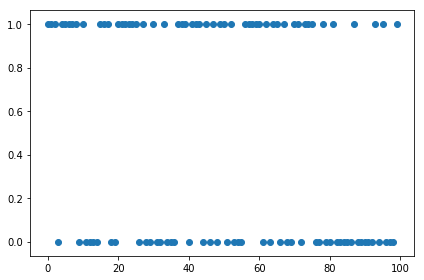

In [72]:
plt.scatter(range(100), rewards[-100:])

/Users/derrkater/anaconda/envs/gym_openai/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


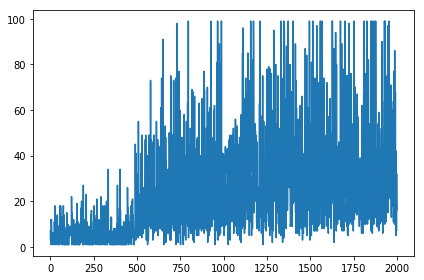

In [73]:
plt.plot(steps)